<a href="https://colab.research.google.com/github/YuriiKlim/AI/blob/Neural_lesson2/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [262]:
import torch
import pandas as pd
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

Дані про морське вухо(молюск)

<div>
<img src="https://m.media-amazon.com/images/I/81-FC5TlLtL.jpg" width="500"/>
</div>

In [263]:
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/abalone.csv')
df.drop(columns=['Type', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight'], inplace=True)

In [264]:
df

,LongestShell,Diameter,Height,Rings
0,0.455,0.365,0.095,15
1,0.350,0.265,0.090,7
2,0.530,0.420,0.135,9
3,0.440,0.365,0.125,10
4,0.330,0.255,0.080,7
...,...,...,...,...
4172,0.565,0.450,0.165,11
4173,0.590,0.440,0.135,10
4174,0.600,0.475,0.205,9
4175,0.625,0.485,0.150,10


Потрібно на основі розмірів молюска спрогнозувати кількість кілець в мушлі `Rings`. Використовуйте процесор cpu

# Завдання 1
Створіть клас Dataset

In [265]:
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.FloatTensor(X.values).to(device)
      self.y = torch.FloatTensor(y.values).to(device)
      self.y = self.y.reshape(-1, 1)

    def __len__(self):
      return len(self.X)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

# Create dataset object
X = df.drop(columns=['Rings'])
y = df['Rings']

dataset = MyDataset(X, y)

# Завдання 2
Створіть DataLoader. Перевірте розміри даних в першому пакеті. Розмір пакетів оберіть самостійно

In [266]:
from torch.utils.data import DataLoader

batch_size = 256
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        generator=torch.Generator(device=device))

In [267]:
X_batch, y_batch = next(iter(dataloader))

In [268]:
X_batch.device

device(type='cuda', index=0)

In [269]:
X_batch.shape

torch.Size([256, 3])

In [270]:
y_batch.shape

torch.Size([256, 1])

# Завдання 3
Створіть нейромережу:
* Кількість шарів оберіть між 1-3
* Виберіть різні функції активації: Relu, LeakyRelu, Swish
* Кілкість нейронів у прихованих шарах повинна **не зростати**

In [271]:
from torch import nn, optim

class Model(nn.Module):
    def __init__(self, input_size=2, hidden_sizes=[4], output_size=1):
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))

        act_func = nn.ELU()

        for i in range(len(hidden_sizes) - 1):
            self.layers.append(act_func)
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))

        self.layers.append(act_func)
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

model = Model(input_size=3, hidden_sizes=[6], output_size=1)

model

Model(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=6, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=6, out_features=1, bias=True)
  )
)

In [272]:
from torchsummary import summary

summary(model, input_size=(3,))

Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─Linear: 2-1                       24
|    └─ELU: 2-2                          --
|    └─Linear: 2-3                       7
Total params: 31
Trainable params: 31
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─Linear: 2-1                       24
|    └─ELU: 2-2                          --
|    └─Linear: 2-3                       7
Total params: 31
Trainable params: 31
Non-trainable params: 0

# Завдання 4
Визначте функцію втрат та оптимізатор

In [273]:
loss_fn = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.99)

# Завдання 5
Натренуйте нейромережу. візміть невелику кількість епох

In [274]:
num_epochs = 100
losses = []

for epoch in range(num_epochs):
    losses_ = []
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        losses_.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    losses.append(np.mean(losses_))

    if epoch % 10 == 0 or epoch == num_epochs -1:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss={losses[-1]}')

Epoch 1/100, Loss=43.81317536971148
Epoch 11/100, Loss=9.67884069330552
Epoch 21/100, Loss=7.783148625317742
Epoch 31/100, Loss=6.886544508092544
Epoch 41/100, Loss=6.663656795726103
Epoch 51/100, Loss=6.683978810029871
Epoch 61/100, Loss=6.378258747213027
Epoch 71/100, Loss=6.610766438876881
Epoch 81/100, Loss=7.272861284368179
Epoch 91/100, Loss=6.633156467886532
Epoch 100/100, Loss=6.3300776341382194


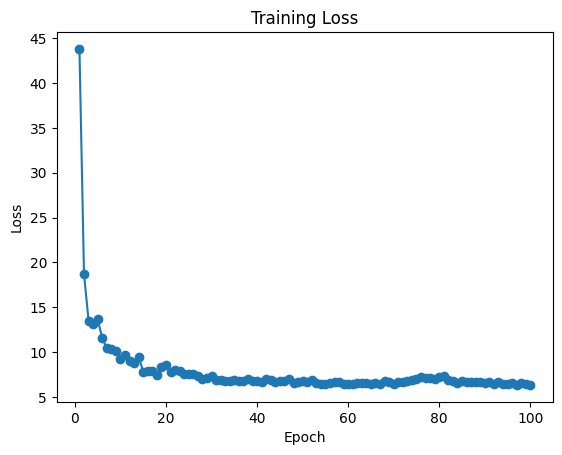

In [275]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [276]:
X.iloc[:1]

,LongestShell,Diameter,Height
0,0.455,0.365,0.095


In [277]:
X_data = torch.FloatTensor(X.iloc[:1].values)
X_data = X_data.to(device)

print(X_data)
print(X_data.shape)

tensor([[0.4550, 0.3650, 0.0950]], device='cuda:0')
torch.Size([1, 3])


# Завдання 6
Збережіть нейромережу та зробіть прогноз

In [278]:
torch.save(model, 'model.pt')

In [279]:
load_model = torch.load('model.pt')

In [280]:
load_model(X_data)

tensor([[7.6851]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [281]:
with torch.no_grad():
  print(load_model(X_data))

tensor([[7.6851]], device='cuda:0')
